In [1]:
from typing import List

import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import networkx as nx
from helpers import eig
from sklearn.cluster import KMeans

# Exercise 3

In [2]:
def plot_station_map(station_numbers: List[int], xs: List[int], ys: List[int]):
    """ Wrapper for plotting stations given their numbers """
    # Since Python index from 0 we subtract 1 on every element
    jv = [sn - 1 for sn in station_numbers]

    # Plot the stations
    plt.imshow(A)
    for i in range(len(jv)):
        icons = ['r+', 'r*', 'ro']
        plt.plot(ys[jv[i]],xs[jv[i]], icons[i])

    plt.figure()

In [3]:
def plot_plastic_timeseries(station_numbers: List[str], mat, timeseries):
    """ Wrapper for plotting plastic measurements at stations. """
    # Since Python index from 0 we subtract 1 on every element
    jv = [sn - 1 for sn in station_numbers]

    # Subset the timeseries
    tv = mat['tv'][0]

    # Plot the time series
    plt.figure()
    plt.plot(tv, timeseries[jv[0],:], '-', label = str(jv[0] + 1))
    plt.plot(tv, timeseries[jv[1],:], '--', label = str(jv[1] + 1))
    plt.plot(tv, timeseries[jv[2],:], '-.', label = str(jv[2] + 1))
    plt.ylabel("Plastic")
    plt.xlabel("Time (days ago)")
    plt.legend()

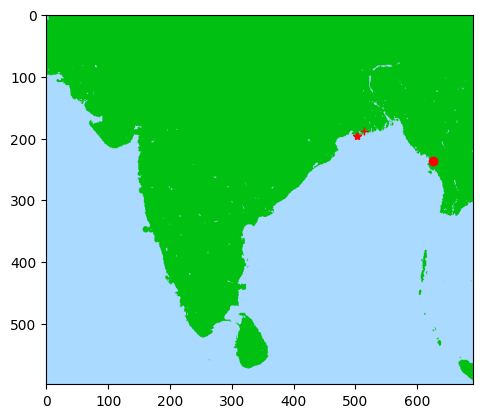

<Figure size 640x480 with 0 Axes>

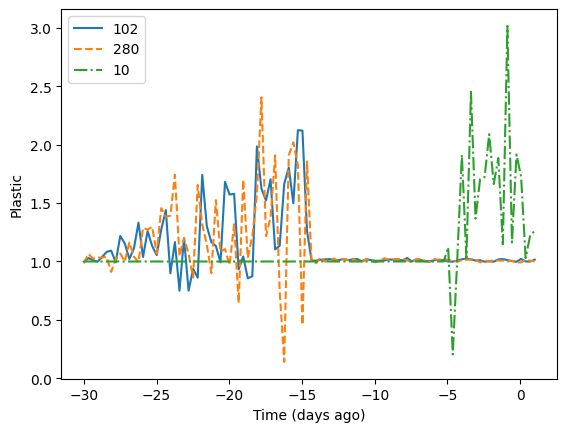

In [4]:
mat = scipy.io.loadmat('bengali_cleanup.mat')
timeseries = mat['timeseries']
x_coords = mat['x_coords']
y_coords = mat['y_coords']

station_numbers = [102, 280, 10]

# Read the map
A = plt.imread('bengali_map.png')

plot_station_map(station_numbers, x_coords, y_coords)
plot_plastic_timeseries(station_numbers, mat, timeseries)

### A)

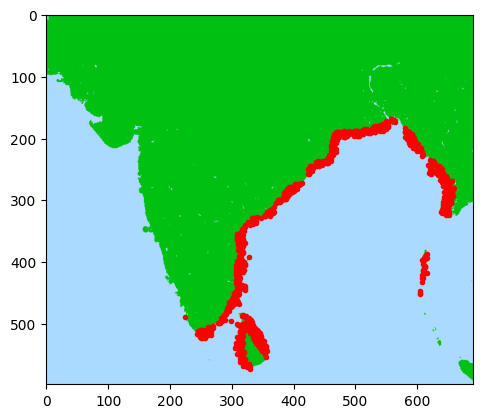

In [6]:
plt.figure()
plt.imshow(A)
for i in range(937):
    plt.plot(y_coords[i],x_coords[i], 'r.')

### B)

In [7]:
# Compute distance matrix in a vectorized way
def build_distance(M):
    S = np.sum(M.T**2, axis=0, keepdims=True)
    S = np.sqrt(np.maximum(0,S + S.T - 2 * M.dot(M.T)))
    np.fill_diagonal(S, 0)
    return S

In [8]:
Dist = build_distance(timeseries)


Time series differences between 280 and 102: 3.35



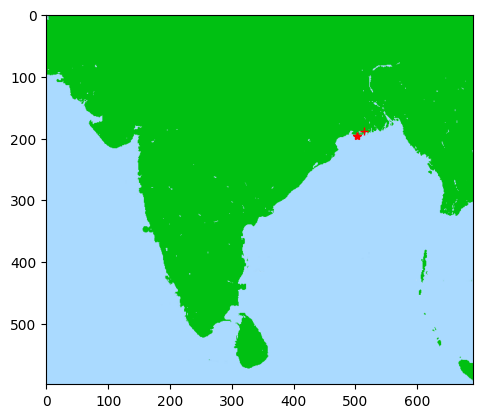

<Figure size 640x480 with 0 Axes>

In [9]:
print(f"""
Time series differences between 280 and 102: {round(Dist[101, 279], 2)}
""")
s1 = [102, 280]
plot_station_map(s1, x_coords, y_coords)


Time series differences between 280 and 102: 4.61



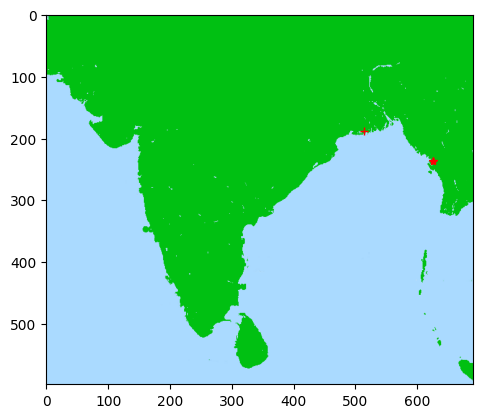

<Figure size 640x480 with 0 Axes>

In [10]:
print(f"""
Time series differences between 280 and 102: {round(Dist[101, 9], 2)}
""")
s1 = [102, 10]
plot_station_map(s1, x_coords, y_coords)


Time series differences between 280 and 10: 4.84



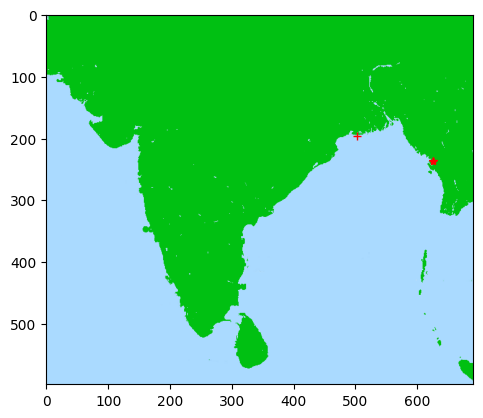

<Figure size 640x480 with 0 Axes>

In [11]:
print(f"""
Time series differences between 280 and 10: {round(Dist[279, 9], 2)}
""")
s1 = [280, 10]
plot_station_map(s1, x_coords, y_coords)

To some extent, the results do make sense. The difference in waste between nearby stations is more alike than that of pollution of stations being further away.

### C)

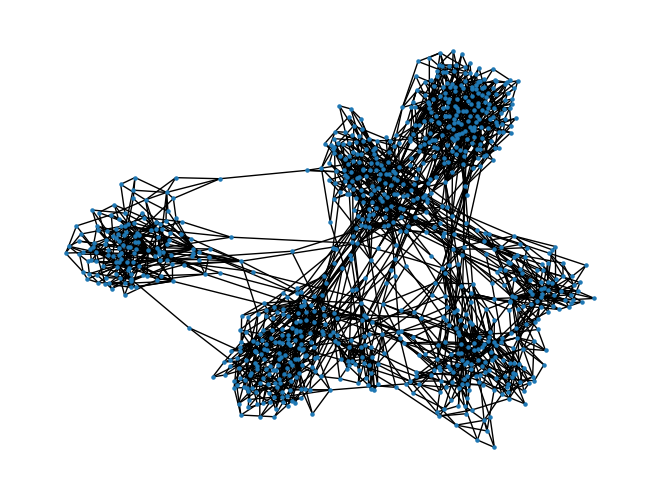

In [12]:
def knn(Dist, k):
    n = Dist.shape[0]
    W = np.zeros((n, n))
    knn_indices = np.argsort(Dist, axis=1)[:, :k+1]
    
    for i in range(n):
        W[i, knn_indices[i, 1:]] = 1
        W[knn_indices[i, 1:], i] = 1
    return W 
    

W = knn(Dist, 3)
G = nx.from_numpy_array(W)
nx.draw(G, node_size = 5)

It is indeed hard to distinguish the 7 clusters from above

### D)

/Users/ludvig/Projects/SF2526-Lab2/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


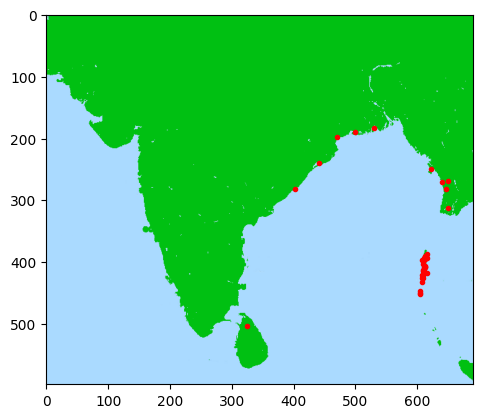

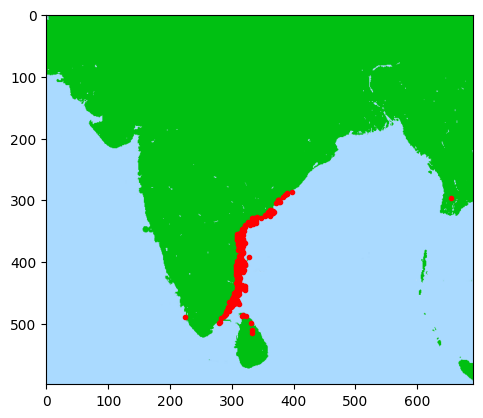

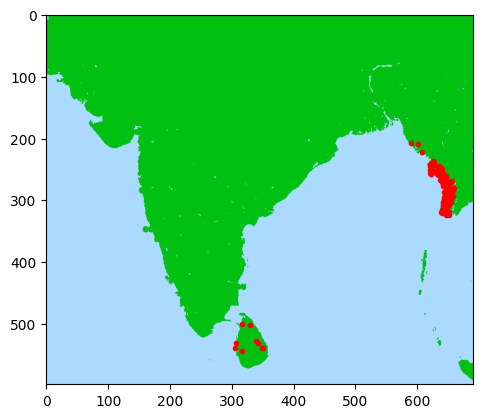

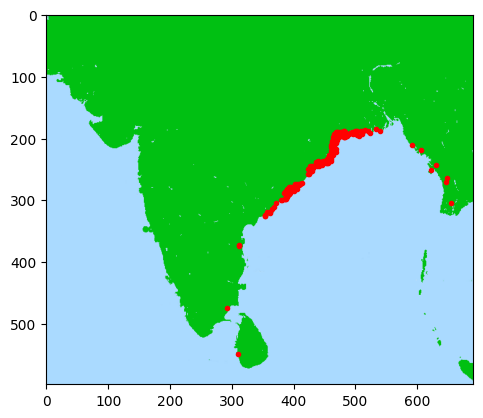

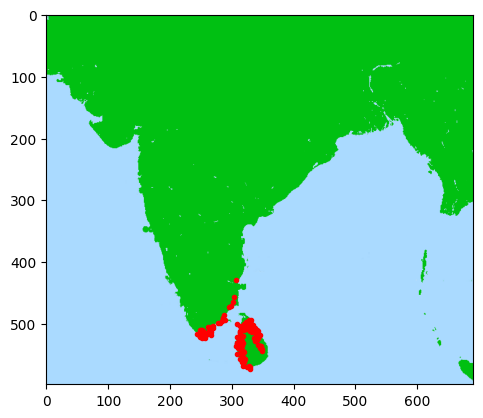

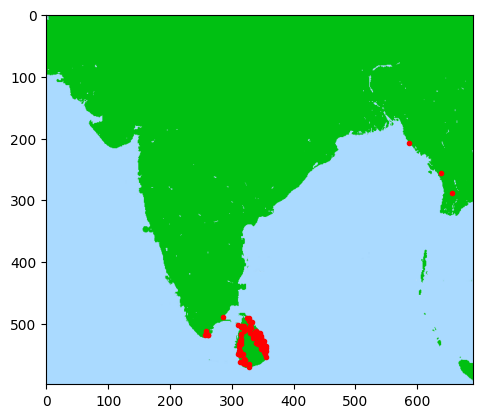

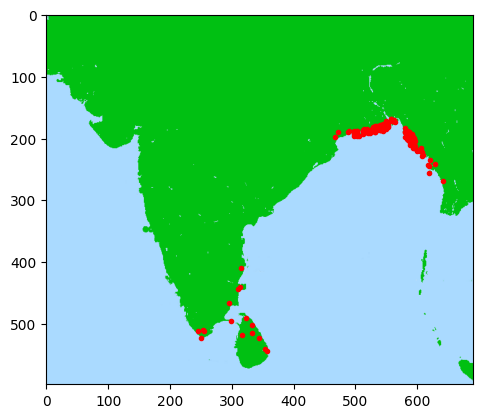

In [13]:
def cluster(W, k):
    D = np.diag(np.sum(W, axis = 1))
    L = D - W
    _, eigvectors = eig(L)
    U = eigvectors[:,:k]
    kmeans = KMeans(n_clusters = k).fit(U)
    return kmeans.labels_

clusters = cluster(W, 7)

def plot_cluster(image, clusters, cluster_nr):
    group = []
    for i in range(len(clusters)):
        if clusters[i] == cluster_nr:
            group.append(i)
    plt.figure()
    plt.imshow(image)
    for i in group:
        plt.plot(y_coords[i],x_coords[i], 'r.')

plot_cluster(A, clusters, 0)
plot_cluster(A, clusters, 1)
plot_cluster(A, clusters, 2)
plot_cluster(A, clusters, 3)
plot_cluster(A, clusters, 4)
plot_cluster(A, clusters, 5)
plot_cluster(A, clusters, 6)

### E)

/Users/ludvig/Projects/SF2526-Lab2/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


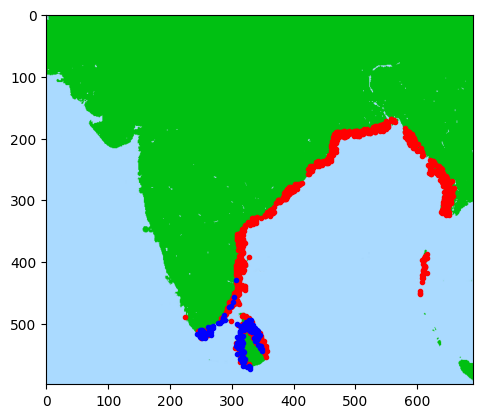

In [14]:
clusters = cluster(W, 2)

group0 = []
group1 = []
for i in range(len(clusters)):
    if clusters[i] == 0:
        group0.append(i)
for i in range(len(clusters)):
    if clusters[i] == 1:
        group1.append(i)
plt.figure()
plt.imshow(A)
for i in group0:
    plt.plot(y_coords[i],x_coords[i], 'r.')
for i in group1:
    plt.plot(y_coords[i],x_coords[i], 'b.')

The general conclusions are still that areas that are similar. Sri lankan waste is similar to that of the south of india, given that the waste around those areas are emphasised by each other. In all other areas along the coast, the waste is similar, given that no nearby island is emphasising the waste.